# Linear Regression by Kalman filter


The Kalman filter is a great tool!!

This is one of my favourite algorithms. It can be used in almost all practical applications in finance.   
And this is the reason I decided to write a notebook on the **applications of the Kalman filter to linear regression**.

I suggest the beginners in this area to have a look at [https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python).     
In my opinion this is one of the best interactive tutorials on Bayesian Filters ever written (it is also the only one that I know). 

## Contents
   - [Real market data](#sec1)
     - [Data Cleaning](#sec1.1) 
   - [Linear regression](#sec2)
   - [The Kalman filter](#sec3)
     - [Kalman regression for the beta](#sec3.1) 

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec

%matplotlib inline
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import minimize
from IPython import display
from scipy.linalg import inv
import FMNM.Kalman_filter as KF

<a id='sec1'></a>

# Real market data

I have collected some market time series from different sources and saved them in `historical_data.csv`, such that now we can play with them.

The tickers are:    
- STOCKS: `AAPL`-> Apple, `EXO.MI`-> Exor (FIAT,Ferrari,etc), `FB`-> Facebook, `GOOGL`-> Google, `UBS`-> UBS, 
- INDECES: `^GSPC`-> [S&P500](https://en.wikipedia.org/wiki/S%26P_500_Index), `^IXIC`-> [Nasdaq](https://en.wikipedia.org/wiki/NASDAQ_Composite), `^VIX`-> [VIX](https://en.wikipedia.org/wiki/VIX) (Implied Volatility of S&P500). 
- BOND:`^TNX`-> Yield 10Y US.  

In [2]:
filename = "data/" + "historical_data.csv"
data = pd.read_csv(filename, index_col="Date", parse_dates=True)
data.tail()

,AAPL,EXO.MI,FB,GOOGL,UBS,^GSPC,^IXIC,^TNX,^VIX
Date,,,,,,,,,
2019-10-28,249.050003,62.939999,189.399994,1288.979980,11.95,3039.419922,8325.990234,1.853,13.11
2019-10-29,243.289993,62.160000,189.309998,1260.660034,12.08,3036.889893,8276.849609,1.835,13.20
2019-10-30,243.259995,65.019997,188.250000,1260.699951,11.84,3046.770020,8303.980469,1.798,12.33
2019-10-31,248.759995,68.720001,191.649994,1258.800049,11.77,3037.560059,8292.360352,1.691,13.22
2019-11-01,255.820007,69.459999,193.619995,1272.250000,11.96,3066.909912,8386.400391,1.728,12.30


<a id='sec1.1'></a>
### Data cleaning

Data can contain NaNs, negative values, zeros and outliers. Let's have a look!

In [3]:
data[data.isna().any(axis=1)].tail()

,AAPL,EXO.MI,FB,GOOGL,UBS,^GSPC,^IXIC,^TNX,^VIX
Date,,,,,,,,,
2019-05-01,208.918625,NaN,193.029999,1173.319946,12.593584,2923.729980,8049.640137,2.511,14.80
2019-05-27,NaN,59.554962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-04,NaN,64.400002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-15,201.740005,NaN,182.589996,1169.319946,10.160000,2847.600098,7766.620117,1.529,21.18
2019-09-02,NaN,61.840000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
(data < 1e-2).any()

AAPL      False
EXO.MI    False
FB        False
GOOGL     False
UBS       False
^GSPC     False
^IXIC     False
^TNX      False
^VIX      False
dtype: bool

Fortunately there are no non-positive values, but there are several NaNs.     
Why?

There can be many reason, but in this case I think it is because of a different calendar (different countries have different holidays). 

##### How to solve this problem?
There are several possibilities:      
-   1)  We may remove the entire line     
-   2)  We may forward fill the missing values     
-   3)  We may backward fill the missing values     
-   4)  We may interpolate or estimate (e.g. regression) the missing values     

All these possibilities have advantages and disvantages. This is a delicate task, for more information see [Imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)).

First of all, let us select the two tickers for the regression analysis.

### Feel free to change the tickers in the next cell:

In [5]:
df = data[["GOOGL", "^GSPC"]]

In this analysis I use the following convention:

- If in one day there is only one value missing, I use the method 2) i.e. **forward filling**. I can justify this choice by saying that if there is no price, it means that the price hasn't changed.

- If in one day both values are missing, then I remove the entire line. (Probably the market was closed on that day) 

In [6]:
history_len = 1000  # lenght of the time series
df.sort_index(inplace=True, ascending=True)  # not necessary in general, but useful
df = df.dropna(axis=1, how="all")  # drops columns with all NaNs
df = df.dropna(axis=0, how="all")  # drops rows with at least one NaN
df = df[-history_len:]
df = df.ffill()  # Forward fill
print("Are there still some NaNs? ")
df.isnull().any()

Are there still some NaNs? 


GOOGL    False
^GSPC    False
dtype: bool

If we call $S_t$ the price under consideration (stock, index, rate) at time $t$, we can work with three types of returns $X_t$:
- Total returns: 
$$ X_t = \frac{S_t}{S_{t-1}} $$
- Linear returns:
$$ X_t = \frac{S_t}{S_{t-1}} - 1 $$
- Logarithmic returns:
$$ X_t = \log \frac{S_t}{S_{t-1}} $$

For now, I prefer to work with log-returns. But feel free to try other options.

In [7]:
returns = "log-returns"

if returns == "log-returns":
    ret = np.log(df / df.shift())[1:]
elif returns == "linear-returns":
    ret = df.pct_change()[1:]
elif returns == "total-returns":
    ret = df / df.shift()[1:]

##### Plot

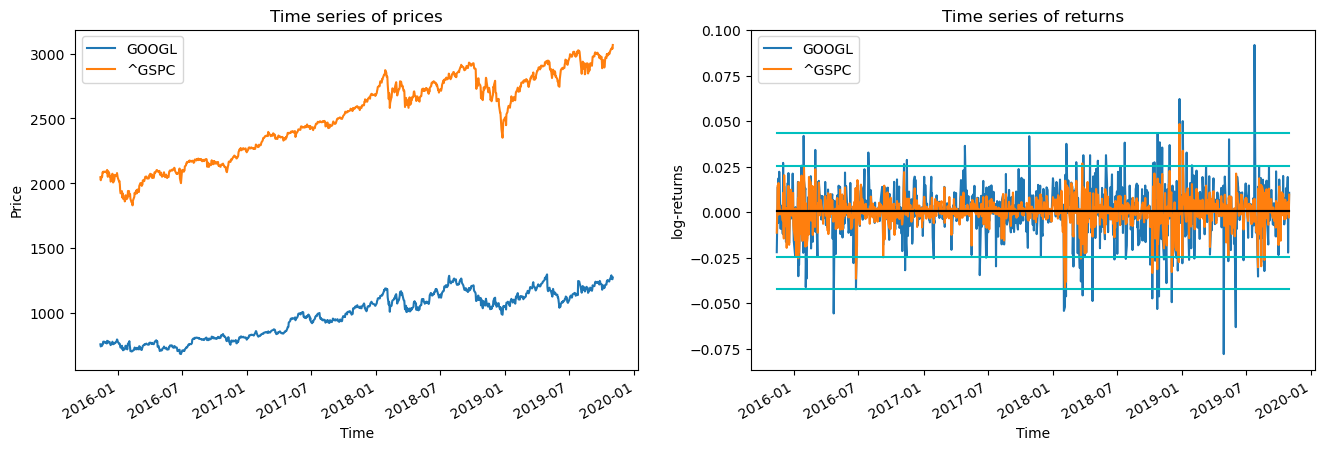

In [8]:
NOSD = 3  # Number Of Standard Deviations
mu = ret.mean()
sig = ret.std()
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(ax=ax1)
ax1.set_title("Time series of prices")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ret.plot(ax=ax2)
ax2.set_title("Time series of returns")
ax2.set_xlabel("Time")
ax2.set_ylabel(returns)
ax2.plot(ret.index, len(ret) * [mu], color="k")
ax2.plot(ret.index, len(ret) * [mu + NOSD * sig], color="c")
ax2.plot(ret.index, len(ret) * [mu - NOSD * sig], color="c")
plt.show()

### What about the outliers?

We can see that there are returns that are quite bigger than $3\sigma$ (three standard deviations).    
If we assume a Normal distribution for the returns, these outliers can create problems.

Wait a second...     
we calculated the standard deviation `ret.std()` using the data containing the ouliers!!     
It means that the value of the standard deviation is aslo affected by the outliers!!

The solution is to use [robust](https://en.wikipedia.org/wiki/Robust_statistics) estimators of the location and the dispersion of a distribution. They work much better in presence of outliers. 

Although there are several alternatives, I prefer to use the **median** and the [MAD](https://en.wikipedia.org/wiki/Median_absolute_deviation). These estimators are more robust than the mean and standard deviation. In the standard deviation, the distances from the mean are squared, so large deviations are weighted more heavily, and thus outliers can heavily influence it. In the MAD instead, the deviations of a small number of outliers are irrelevant. 

As explained on [wiki](https://en.wikipedia.org/wiki/Median_absolute_deviation), in order to use the MAD as a consistent estimator of the standard deviation, we have to take 

$$ \sigma = k \, \text{MAD} $$

where under the assumption of Normal distribution, $k = 1.4826$.

In [9]:
median = ret.median()
MAD = ret.apply(ss.median_abs_deviation)
sig_robust = MAD * 1.4826
print("STD DEV: \n", sig)
print("")
print("Robust STD DEV: \n", sig_robust);

STD DEV: 
 GOOGL    0.014242
^GSPC    0.008324
dtype: float64

Robust STD DEV: 
 GOOGL    0.010268
^GSPC    0.005255
dtype: float64


In [10]:
outliers = ret[ret[np.abs(ret - median) > NOSD * sig_robust].any(axis=1)]  # outliers
dret = ret.drop(outliers.index)  # series of returns without outliers

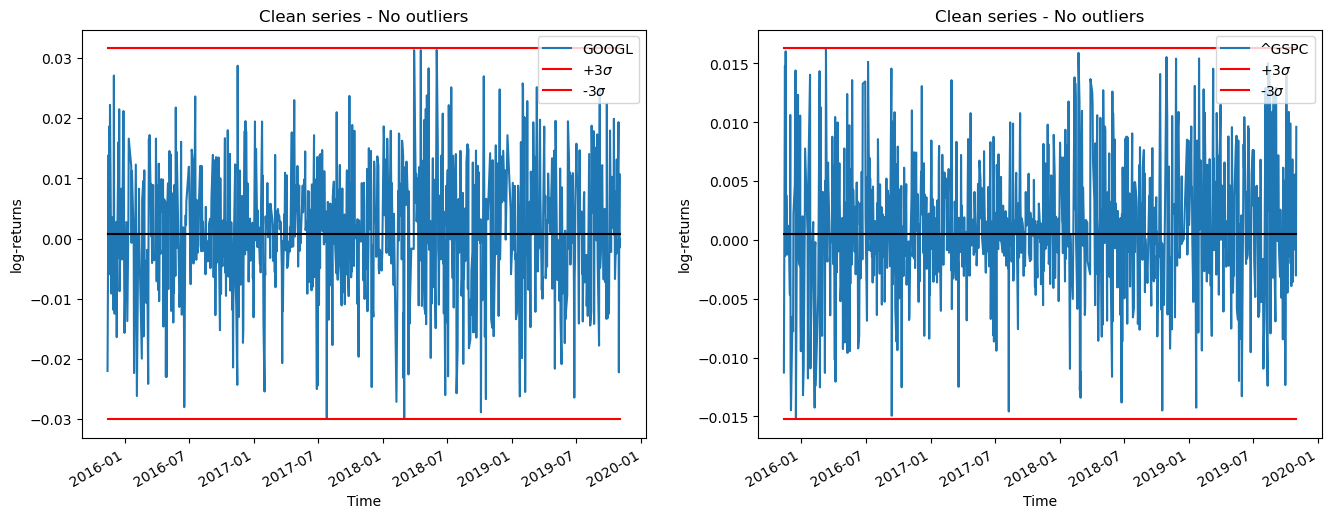

In [11]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for ax, col in zip([ax1, ax2], dret.columns):
    dret[col].plot(ax=ax)
    ax.set_title("Clean series - No outliers")
    ax.set_xlabel("Time")
    ax.set_ylabel(returns)
    ax.plot(dret.index, len(dret) * [median[col]], color="k")
    ax.plot(dret.index, len(dret) * [median[col] + NOSD * sig_robust[col]], color="r", label="+3$\sigma$")
    ax.plot(dret.index, len(dret) * [median[col] - NOSD * sig_robust[col]], color="r", label="-3$\sigma$")
    ax.legend(loc="upper right")
plt.show()

In [12]:
print(
    "We have reduced the initial DIRTY series of returns of size {} to the \
new CLEAN series of size {}.".format(
        len(ret), len(dret)
    )
)

We have reduced the initial DIRTY series of returns of size 999 to the new CLEAN series of size 911.


<a id='sec2'></a>
# Linear regression

Let me recall some well known notions about [linear regression](https://en.wikipedia.org/wiki/Linear_regression).     The linear model is:

$$ Y = \alpha + \beta X + \epsilon $$

where 
- X is the predictor variable
- Y is the response variable
- $\epsilon$ is the error such that $Std[\epsilon]= \sigma$ and $Cov[\epsilon,X]=0$. 

An additional useful hypothesis is to consider normal errors $\epsilon \sim \mathcal{N}(0,\sigma^2)$. This assumption permits to use MLE methods and to calculate confidence intervals.

The parameters $\alpha$ and $\beta$ can be estimated by:

$$ \mathbb{E}[Y] = \alpha + \beta \mathbb{E}[X]  \quad \Rightarrow \quad \alpha = \mathbb{E}[Y] - \beta \mathbb{E}[X]$$

and, using the bilinear property of the Covariance:

$$ Cov[X,Y] = Cov[ X, \alpha + \beta X + \epsilon ] = \beta Var[X] $$

$$ \beta = \frac{Cov[X,Y]}{Var[X]} $$

If we have some observations $x_i$, we can use the linear regression as a model for the respose variables only (which are random) $Y_i = \alpha + \beta x_i + \epsilon_i$, where the $\epsilon_i$ are uncorrelated. The expectation $\mathbb{E}[Y_i]$ is intended as a conditional expectation $\mathbb{E}[Y_i|x_i]$.     

If we have two sets of data $y_i$ and $x_i$ for $1 \leq i \leq n$, where $y_i$ are the realizations of $Y_i$, we call:
$\bar x = \frac{1}{n} \sum_{i=1}^n x_i$ and $\bar y = \frac{1}{n} \sum_{i=1}^n y_i$.      
We also define 

$$S_{xx} = \sum_{i=1}^n (x_i - \bar x)^2 \quad S_{yy} = \sum_{i=1}^n (y_i - \bar y)^2  \quad S_{xy} = \sum_{i=1}^n (x_i - \bar x)(y_i - \bar y) $$  

The estimator $\hat \beta$ and $\hat \alpha$ for $\beta$ and $\alpha$ are: 

$$ \hat \beta = \frac{S_{xy}}{S_{xx}} \quad \quad \hat \alpha = \bar y - \beta \bar x $$

These estimators are the **least squares** estimators. They are also **MLE estimators** and **BLUE** (best linear unbiased estimators).     
Of course $\mathbb{E}[\hat \beta]=\beta$ and $\mathbb{E}[\hat \alpha]=\alpha$ (they are unbiased). We also have:

$$ Var[\hat \beta] = \frac{\sigma^2}{S_{xx}} \quad Var[\hat \alpha] = \frac{\sigma^2}{n S_{xx}}\sum_{i=1}^n x_i^2 $$

and under the assumption of Normal errors, the estimators are also Normal distributed. (the square root of the variances above, is called "standard error" of $\hat \alpha$ and $\hat \beta$)       
The residual estimator is $\hat \epsilon_i = y_i - \hat \alpha - \hat \beta x_i$. We can define the estimator for $\sigma$.
- MLE (biased)  
$$ \hat \sigma^2 = \frac{1}{n} \sum_{i=1}^n \epsilon_i^2 $$
it has $\mathbb{E}[\hat \sigma] = \frac{n-2}{n} \sigma^2 $.
- Unbiased version:
$$ S^2 = \frac{n}{n-2}\hat \sigma^2 = \frac{1}{n-2} \sum_{i=1}^n \epsilon_i^2 $$
Under the normal assumption of errors, it is distributed as $\frac{(n-2)S^2}{\sigma^2} \sim \chi^2_{n-2}$.

Confidence intervals can be obtained from the statistics:

$$ \frac{\hat \alpha - \alpha}{ S \sqrt{(\sum_{i=1}^n x_i^2)/nS_{xx}} } \sim t_{n-2} \quad and \quad  
\frac{\hat \beta - \beta}{ S \sqrt{S_{xx}} } \sim t_{n-2} $$

where the parameter $\sigma$ is replaced by its unbiased estimator $S$. For a short (but complete) description of confidence intervals you can have a look at the notebook **1.2**.      
For more info see [CI for linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression#Confidence_intervals), or the deeper presentation in Chapter 11.3 of [1].

Last, let us recall (with no proof) that if we call $\hat y_i = \hat \alpha + \hat \beta x_i$, then

$$ S_{yy} = \sum_{i=1}^n (y_i - \bar y)^2 =\; \sum_{i=1}^n (\hat y_i - \bar y)^2 + \sum_{i=1}^n (y_i - \hat y_i)^2  
=\; \frac{S^2_{xy}}{S_{xx}} + \sum_{i=1}^n \hat \epsilon_i^2 .$$

We can define the **coefficient of determination $r^2$** such that $0 \leq r^2 \leq 1$, as

\begin{align*}
r^2 &=\; \frac{\sum_{i=1}^n (\hat y_i - \bar y)^2}{\sum_{i=1}^n (y_i - \bar y)^2} =\; \frac{S_{xy}^2}{S_{xx}S_{yy}} \\
&=\; 1 - \frac{\sum_{i=1}^n (\hat \epsilon_i)^2}{\sum_{i=1}^n (y_i - \bar y)^2}.
\end{align*}

In [13]:
X = dret[dret.columns[1]]
Y = dret[dret.columns[0]]
print("In our regression Y is {} and X is {}".format(dret.columns[0], dret.columns[1]))

In our regression Y is GOOGL and X is ^GSPC


In [14]:
b_ss, a_ss, r_ss, _, std_err_ss = ss.linregress(X, Y)
print(
    "We can use one of the many python functions:\nbeta: {0:6f}, alpha: {1:6f}, R2: {2:6f}, \
standard error: {3:6f}.".format(
        b_ss, a_ss, r_ss**2, std_err_ss
    )
)

beta_tot_OLS = np.cov(X, Y, ddof=1)[0, 1] / np.var(X, ddof=1)
alpha_tot_OLS = np.mean(Y) - beta_tot_OLS * np.mean(X)
res = Y - beta_tot_OLS * X - alpha_tot_OLS
std_eps_OLS = np.std(res, ddof=2)
print("\nOr I can estimate by myself:\nbeta: {}, alpha: {}, sigma: {}".format(beta_tot_OLS, alpha_tot_OLS, std_eps_OLS))

We can use one of the many python functions:
beta: 1.181743, alpha: 0.000058, R2: 0.428090, standard error: 0.045304.

Or I can estimate by myself:
beta: 1.1817426272884215, alpha: 5.772407285412843e-05, sigma: 0.007842859851366457


Come on....Let's compute everything: (with the help of the scalar product between vectors `@`)

In [15]:
n = len(X)
x_mean = np.mean(X)
y_mean = np.mean(Y)
Sxx = (X - x_mean) @ (X - x_mean)
Syy = (Y - y_mean) @ (Y - y_mean)
Sxy = (X - x_mean) @ (Y - y_mean)
beta_hat = Sxy / Sxx
alpha_hat = y_mean - beta_hat * x_mean  # beta and alpha
print("beta: {} and alpha: {}".format(beta_hat, alpha_hat))
epsilon = Y - beta_hat * X - alpha_hat  # residuals
S2 = epsilon @ epsilon / (n - 2)
S = np.sqrt(S2)  # unbiased estimator
print("sigma: {}".format(S))
var_beta = S2 / Sxx  # variance of beta
var_alpha = (X @ X) * S2 / (Sxx * n)  # variance of alpha
s_b = np.sqrt(var_beta)  # standard error for beta
s_a = np.sqrt(var_alpha)  # standard error for alpha
R2 = Sxy**2 / (Sxx * Syy)
print("Standard Error for beta: ", s_b)
print("R squared: {}".format(R2))
CI_b = ss.t.interval(0.95, n - 2, loc=beta_hat, scale=s_b)
b_up = CI_b[0]
b_down = CI_b[1]
CI_a = ss.t.interval(0.95, n - 2, loc=alpha_hat, scale=s_a)
print("Confidence intervals for beta: ", CI_b)
print("Confidence intervals for alpha: ", CI_a)

beta: 1.1817426272884215 and alpha: 5.772407285412843e-05
sigma: 0.007842859851366457
Standard Error for beta:  0.04530406599209334
R squared: 0.42809009281099913
Confidence intervals for beta:  (1.0928299019730954, 1.2706553526037476)
Confidence intervals for alpha:  (-0.0004599474292502449, 0.0005753955749585017)


The intercept $\alpha$ is (always) almost zero. Therefore it is not relevant for the future analysis.   

##### Plot:

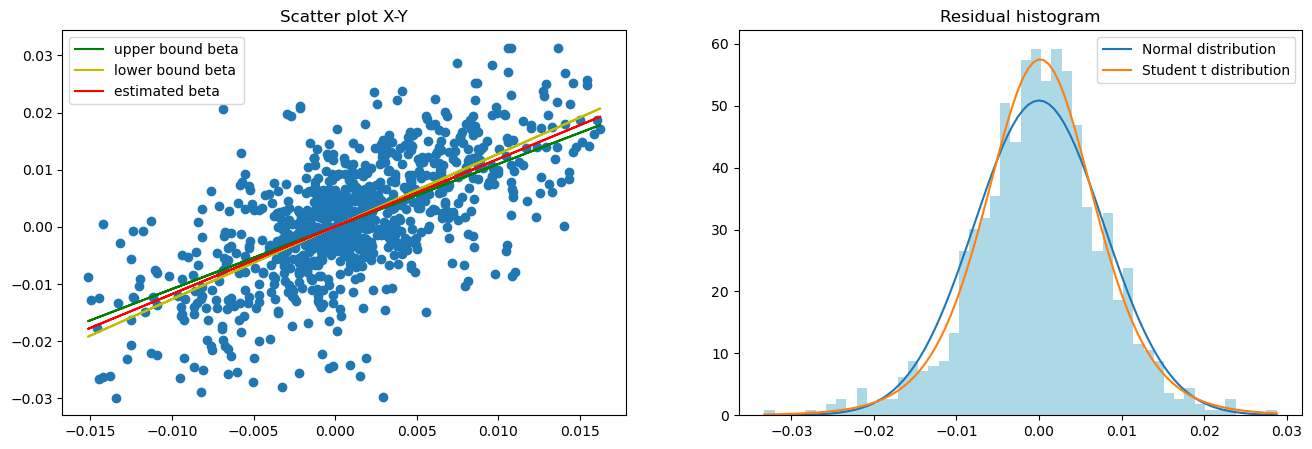

In [16]:
x = np.linspace(res.min(), res.max(), 100)  # res are the residuals

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(X, Y)
ax1.set_title("Scatter plot X-Y")
ax1.plot(X, alpha_hat + b_up * X, color="g", label="upper bound beta")
ax1.plot(X, alpha_hat + b_down * X, color="y", label="lower bound beta")
ax1.plot(X, alpha_hat + beta_hat * X, color="red", label="estimated beta")
ax1.legend(loc="upper left")
ax2.plot(x, ss.norm.pdf(x, 0, S), label="Normal distribution")
params = ss.t.fit(res)
ax2.plot(x, ss.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax2.hist(res, bins=50, density=True, facecolor="LightBlue")
ax2.legend()
ax2.set_title("Residual histogram")
plt.show()

The first thing we notice is that, although we removed the outliers, the Normal fit is still not so good.     
The distribution is better described by a Student t distribution with 

In [17]:
print("Degrees of freedom of fitted t distribution: ", params[0])

Degrees of freedom of fitted t distribution:  7.247881899338388


However, it is much easier to mantain the Normal assumption, because it permits to use confidence intervals and... also... the Kalman filter!!

<a id='sec3'></a>
# The Kalman filter

I do not have space and time to explain the meaning and the details of the [Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter) in this notebook. I assume the reader already has a basic knowledge. Otherwise, for a pedagogical exposition, I suggest to have a look at the tutorial mentioned at the top. The presentation on wikipedia, although very short, is also quite clear.

Important things to remember:  the KF (Kalman Filter) assumes a linear dynamics for the true state $\mathbf x_k$ with $k \in \mathbb{N}$, and Normally distributed errors.    

$$
\begin{aligned}
\mathbf x_{k} &= \mathbf F_k \mathbf x_{k-1} + \mathbf w_k & \text{with}  \quad \mathbf w_k \sim \mathcal{N}(0, \mathbf Q_k)  \\
\mathbf z_k &=  \mathbf H_k \mathbf x_{k} + \mathbf v_k  & \text{with}  \quad \mathbf v_k \sim \mathcal{N}(0, \mathbf R_k)  \\
\\\end{aligned}
$$

The first equation is the **process equation** for the true state,
where $\mathbf F_k$ is the *state transition function* (or matrix), and $\mathbf w_k$ is the process noise with covariance $\mathbf Q_k$.     
The second equation is the **measurement equation**, where $\mathbf z_k$ are the measurement of the true state $\mathbf x_k$. The term $\mathbf H_k$ is the *measurement function* (or matrix), and $\mathbf v_k$ is the measurement noise with covariance $\mathbf R_k$. 

The Kalman filter equations, taken from [here](https://en.wikipedia.org/wiki/Kalman_filter#Underlying_dynamical_system_model), are:

$$
\begin{aligned}
\text{Predict Step}\\
\hat{\mathbf x}_{k\mid k-1} &= \mathbf F_k\hat{\mathbf x}_{k-1\mid k-1}  \hspace{10em} \text{(a priori) state mean prediction} \\
\mathbf P_{k\mid k-1} &=  \mathbf F_k \mathbf P_{k-1\mid k-1} \mathbf F_k^\mathsf T + \mathbf Q_k \hspace{6.5em} \text{(a priori) state covariance prediction} \\        	
\\
\text{Helper variables}\\
\tilde{\mathbf y}_k &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k-1} \hspace{9.3em} \text{pre-fit residuals}\\
\mathbf{S}_k &= \mathbf H_k \mathbf P_{k\mid k-1} \mathbf H_k^\mathsf T + \mathbf R_k \hspace{8em} \text{pre-fit measurement covariance} \\
\mathbf K_k &= \mathbf P_{k\mid k-1}\mathbf H_k^\mathsf T \mathbf{S}_k^{-1} \hspace{10em} \text{Kalman Gain}\\
\\
\text{Update Step}\\
\hat{\mathbf x}_{k\mid k} &= \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k \hspace{9.4em} \text{(a posteriori) state estimate}\\
\mathbf P_{k|k} &= (\mathbb{1} - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1} \hspace{8em} \text{(a posteriori) covariance estimate} \\
\\
\tilde{\mathbf y}_{k\mid k} &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k} \hspace{10em} \text{post-fit residuals}\\
\\\end{aligned}
$$

The notation $\hat {\mathbf {x} }_{k\mid k-1}$ represents the (a priori) estimate of $\mathbf {x}$ at time $k$ given an observation (a measurement) at time $k-1$. Instead, $\hat {\mathbf {x} }_{k\mid k}$ represents the (a posteriori) estimate of $\mathbf {x}$ at time $k$ given an observation at time $k$.

##### Comments:
- Residuals are computed in the measurement space.     
The variable $\mathbf x$ needs to be transformed by $\mathbf H$ before the subtraction with $\mathbf z$.
- The (a priori) covariance is simply the conditional covariance of the process dynamics:

$$\begin{aligned}
\mathbf P_{k\mid k-1} = \text{Cov}[\mathbf x_k \mid \mathbf x_{k-1}] &= \text{Cov}[ \mathbf F_k \mathbf x_{k-1} \mid \mathbf x_{k-1}] + \text{Cov}[\mathbf w_k \mid \mathbf x_{k-1}] \\
                     &= \mathbf F_k \, \text{Cov}[\mathbf x_{k-1} \mid \mathbf x_{k-1}]\, \mathbf F_k^T + \mathbf Q_k \\
                     &= \mathbf F_k \, \mathbf P_{k-1\mid k-1}\, \mathbf F_k^T + \mathbf Q_k 
\end{aligned}$$
- The term $\mathbf{S}_k$ is the conditional covariance of the measurement.  

$$\begin{aligned}
\mathbf S_{k} = \text{Cov}[\mathbf z_k \mid \mathbf x_{k-1}] &= \text{Cov}[ \mathbf H_k \mathbf x_{k} \mid \mathbf x_{k-1}] + \text{Cov}[\mathbf v_k \mid \mathbf x_{k-1}] \\
                     &= \mathbf H_k \, \text{Cov}[\mathbf x_{k} \mid \mathbf x_{k-1}]\, \mathbf H_k^T + \mathbf R_k 
\end{aligned}$$
- Of course $\mathbf w_{k}$ and $\mathbf v_{k}$ are independent of $\mathbf x_{k-1}$.

##### Marginal probability distribution

Let us recall the [marginal distribution](https://en.wikipedia.org/wiki/Kalman_filter#Marginal_likelihood), where the hidden state variables $\mathbf x_k$ are integrated out.    
If we define $\mathbf z = (\mathbf z_0, \mathbf z_1, ... )$, we have:

$$ \mathbb{P}(\mathbf z) = \prod_{k} \mathcal{N} \bigg( \mathbf z_k; \; \mathbf H_k \mathbf x_{k \mid k-1}, \mathbf S_k \bigg) $$

where $\mathbf H_k \mathbf x_{k \mid k-1}$ and $\mathbf S_k$ are the mean and covariance of normal distribution of $\mathbf z_k$.

## Kalman regression model

Let us introduce the model for the Kalman regression. 
The state variable is $\mathbf x_k = \bigg( \begin{array}{c} \alpha_k \\ \beta_k \end{array} \bigg)$. These variables are **hidden** i.e. they are not measurable directly. We can only measure $x_k$ and $y_k$.     
#### Notation issue!
Here I use the variable $y_k$ to indicate the response variable in the regression and not the residual variable of the Kalman filter. Above I wanted to use the same notation of wikipedia. Below, I indicate the Kalman residuals with `r_k`. 

The model equations are:
##### process equation:
$$
\biggl(\begin{array}{c} \alpha_k\\ \beta_k \end{array}\biggr) = 
\biggl(\begin{array}{cc} 1 & 0\\ 0 & 1 \end{array}\biggr)
\biggl(\begin{array}{c} \alpha_{k-1}\\ \beta_{k-1} \end{array}\biggr) 
+ \biggl(\begin{array}{c} \eta^{\alpha}_k\\ \eta^{\beta}_k \end{array}\biggr) \quad \text{with}  \quad 
\biggl(\begin{array}{c} \eta^{\alpha}_k\\ \eta^{\beta}_k \end{array}\biggr) \sim \mathcal{N}(0, \mathbf Q_k) 
\quad \text{and} \quad \mathbf Q_k = \biggl(\begin{array}{cc} \sigma^2_{\alpha} & 0\\ 0 & \sigma^2_{\beta} \end{array}\biggr) $$
##### measurement equation:
$$
y_k =   \bigl(\begin{array}{cc} 1 & x_k \end{array}\bigr) \biggl(\begin{array}{c} \alpha_k\\ \beta_k \end{array}\biggr)
+ \epsilon_k  \quad \text{with}  \quad \epsilon_k \sim \mathcal{N}(0, \sigma^2_{\epsilon})  \\
$$

We see that the transition matrix is the identity $\mathbf F_k = \mathbb 1$, and the measurement matrix is $\mathbf H_k = \bigl(\begin{array}{cc} 1 & x_k \end{array}\bigr) $.    
We also assume $\eta^{\alpha}_k$ and $\eta^{\beta}_k$ uncorrelated.

### Training set

I also rename the columns in order to clarify which column is the X and which is the Y.    
I overwrite the variables $X$, $Y$ used before.  

In [18]:
Y = dret.columns[0]
X = dret.columns[1]

In [19]:
training_size = 250
ret_train = dret.iloc[:training_size]
ret_test = dret.iloc[training_size:]

In [20]:
beta_tr, alpha_tr, _, _, _ = ss.linregress(ret_train[X], ret_train[Y])
resid_tr = ret_train[Y] - beta_tr * ret_train[X] - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)  # a possible initial guess for var_eps
print("In the training set the OLS estimators of")
print("alpha_tr = ", alpha_tr)
print("beta_tr = ", beta_tr)
print("var_eps = ", var_eps_ols)

In the training set the OLS estimators of
alpha_tr =  0.0002276440411573649
beta_tr =  0.9751772551661367
var_eps =  6.286775484858256e-05


### Rolling alpha and beta

Here I calculate the OLS $\alpha$ and $\beta$ in the test set, using a rolling window. 

In [21]:
rolling_window = 50
rolling_beta = []
rolling_std_err = []
rolling_alpha = []

for i in range(len(ret_test)):
    ret_temp = ret.iloc[1 + i + training_size - rolling_window : 1 + i + training_size]
    beta_temp, alpha_temp, _, _, std_err_temp = ss.linregress(ret_temp[X], ret_temp[Y])
    rolling_beta.append(beta_temp)
    rolling_std_err.append(std_err_temp)
    rolling_alpha.append(alpha_temp)
ret_test = ret_test.assign(ols_beta=np.array(rolling_beta))
ret_test = ret_test.assign(ols_std_err=np.array(rolling_std_err))
ret_test = ret_test.assign(ols_alpha=np.array(rolling_alpha))

### Implementation of the Kalman filter for $\alpha$ and $\beta$

In the following cell I decided to initialize the state $\mathbf x_0 = \bigg( \begin{array}{c} \alpha_0\\ \beta_0 \end{array} \bigg)$ using the OLS values calculated with the data in the training set. The initial covariance matrix is set to $P_0= 0.1 \cdot \mathbb{1}$.    
The variance parameters are set to $\sigma^2_{\alpha}=0.0000001$ and $\sigma^2_{\beta}=0.01$.

Intuitively, it makes sense to design the $\beta$ process dynamics with a standard deviation $\sigma_{\beta}=0.1$. The error describes how the beta changes over time, e.g. if $\sigma_{\beta}=0$ the beta remains constant, if $\sigma_{\beta}=100$ the beta can assume unreasonable values. If, for instance, the current value of beta is $1$, with $68.3\%$ probability at the next time step the beta will be inside the interval $[0.9, 1.1]$ ( by the [three-sigma rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)).    
The same argument works for the choice of the variance of $\alpha$.

The parameter $\sigma^2_{\epsilon}$ is set equal to the OLS standard deviation estimate, computed in the training set.  

**All these values must be calibrated using the training dataset!**. This is a difficult task because the variables are not observable!      
In general, **the filter designer has an important role in the selection of the process and model errors.** 
The parameters should be chosen in order to avoid overfitting/underfitting and to avoid unrealistic values. 

Possible methods (but there are more) are:
- (1) Using reasonable intuitive assumptions (such as the assumption I used above)
- (2) Compute the rolling $\alpha$ and $\beta$ in the training set and calculate the variances. Nevertheless, these values will depend on the selected time window.
- (3) Using MLE method. Later I will apply it in a simplified model.

A useful thing to do, is to create a **validation set**. This is an additional set that can be created as a part of the training set. (I will not make use of it in this notebook, although it can be very useful)       
We can run the Kalman filter on the validation set and check if the estimated parameters produce good results.   
For instance, we could verify the intuitive assumption in (1), the choice of the rolling window in (2), and the quality of the MLE estimator. In case of bad results, we can repeat the estimation in the training set under different assumptions.

#### Important!
If you have changed the tickers, the parameters described above need to be changed as well.

In [22]:
x = np.array([[alpha_tr], [beta_tr]])  # initial mean of alpha and beta
P = 0.1 * np.eye(2)  # initial covariance of alpha and beta
eta_alpha = 0.0000001  # variance of the alpha process
eta_beta = 0.01  # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])  # process covariance matrix
R = np.array([[var_eps_ols]])  # variance for the measurement - 1 dim
F = np.eye(2)  # transition matrix
H = np.vstack((np.ones(len(ret_test)), ret_test[X].values)).T  # measurement matrix

In [23]:
alphas, betas = np.full(len(ret_test), np.NaN), np.full(len(ret_test), np.NaN)
for i, y in enumerate(ret_test[Y]):
    # predict
    x = F @ x
    P = (F @ P @ F.T) + Q

    # update
    S = (H[None, i] @ P @ H[None, i].T) + R  # Here S is a scalar
    K = (P @ H[None, i].T) @ inv(S)
    r = y - H[None, i] @ x  # residuals
    x = x + K @ r  # v is a scalar.
    P = P - K @ H[None, i] @ P  # K @ H[None,i] is an outer product

    alphas[i] = x[0, 0]
    betas[i] = x[1, 0]

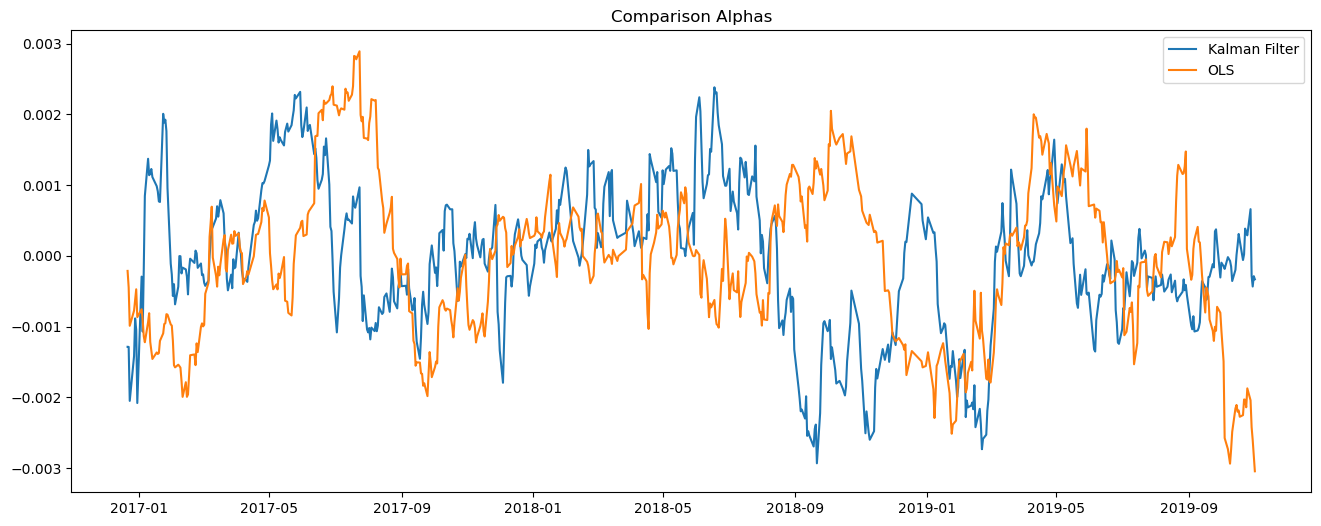

In [24]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test.index, alphas, label="Kalman Filter")
plt.plot(ret_test["ols_alpha"], label="OLS")
plt.legend()
plt.title("Comparison Alphas")
plt.show()

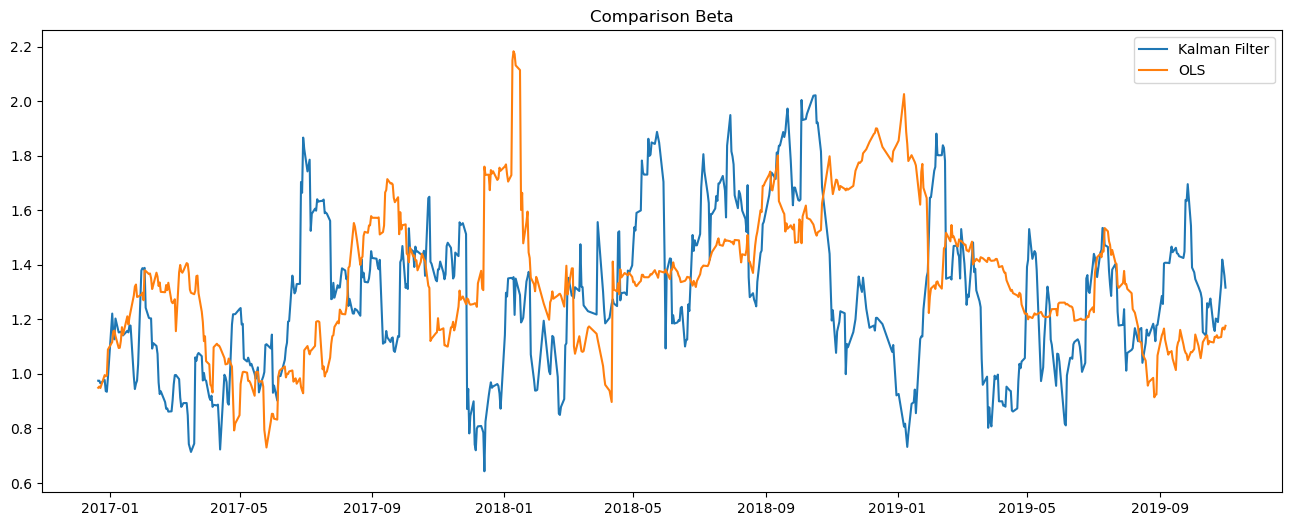

In [25]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test.index, betas, label="Kalman Filter")
plt.plot(ret_test["ols_beta"], label="OLS")
plt.legend()
plt.title("Comparison Beta")
plt.show()

#### Comments

- Looking at the two plots above, we can see that the curves are very similar. An important thing to notice is that the OLS is shiftet on the right i.e. **OLS is delayed!** The Kalman estimates can reflect much better the true (spot) value of the state.   
- The filter is very robust with respect to initial guesses. If, for instance, you try to set `P = 100 * np.eye(2)`, you will see that it will converge quickly to a "reasonable" value. 
- In the matrix `H[None,i]` I had to use the keyword `None` in order to maintain the information of the array dimensions, `H[None,0].shape = (1,2)`. This is a bad feature of the language. Python automatically removes dimensions of a subarray i.e. `H[0].shape = (2,)`.   
- `K @ H[None,i]` is an outer product of dimension $(2,2) = (2,1) \times (1,2)$.
- I used inv(S) to compute the inverse of S. In the notebook **A1** I repeated many times that inverting matrices is bad. But for the Kalman filter, since usually S has small rank (here S is a scalar), we can make an exception :) 

#### PROS
The Kalman filter does not need an entire dataset (or time window) to estimate the current state. **It just needs ONE measurement!**     
The OLS estimate, instead, depends on the length of the time window, and it never reflects the spot value of the state because it is affected by past data.
#### CONS
The Kalman filter performances are strongly dependent on the process and measurement errors!!     
These values are not always measurable, and are hard to calibrate. 

<a id='sec3.1'></a>
## Kalman regression for the $\beta$

We have seen that $\alpha \approx 0$ and that it does not vary that much.     
For this reasons, the parameter alpha is usually not considered as a relevant parameter. 
##### Comment:
This is in accordance with the well known Capital Asset Pricing Model [CAPM](https://en.wikipedia.org/wiki/Capital_asset_pricing_model), that assumes $\alpha=0$. 

Therefore we can simplify the process dynamics by assuming that it is a simple constant $\alpha_k = \alpha$. For simplicity we can set $\alpha=0$, but now I want to present the general case $\alpha \not= 0$.

##### Process equation:
$$
\biggl(\begin{array}{c} \alpha\\ \beta_k \end{array}\biggr) = 
\biggl(\begin{array}{cc} 1 & 0\\ 0 & 1 \end{array}\biggr)
\biggl(\begin{array}{c} \alpha\\ \beta_{k-1} \end{array}\biggr) 
+ \biggl(\begin{array}{c} 0\\ \eta_k \end{array}\biggr) \quad \text{with}  \quad 
\eta_k \sim \mathcal{N}(0, \sigma^2_{\eta}) $$

##### Measurement equation:
$$
y_k =   \bigl(\begin{array}{cc} 1 & x_k \end{array}\bigr) \biggl(\begin{array}{c} \alpha\\ \beta_k \end{array}\biggr)
+ \epsilon_k  \quad \text{with}  \quad \epsilon_k \sim \mathcal{N}(0, \sigma^2_{\epsilon})  \\
$$

Now, we can obtain a simple expression for the Kalman filter variables:
##### Predict:
$$ \beta_{k \mid k-1} = \beta_{k-1 \mid k-1}  \quad \text{and} \quad  P_{k \mid k-1} = P_{k-1 \mid k-1} + \sigma_{\eta}^2. $$
##### Variables:
$$ r_k = y_k - \alpha - \beta_{k \mid k-1}  x_k  $$

$$ S_k = \bigl(\begin{array}{cc} 1 & x_k \end{array}\bigr) 
\biggl(\begin{array}{cc} 0 & 0 \\ 0 & P_{k \mid k-1} \end{array}\biggr)
\biggl(\begin{array}{c} 1\\ x_k \end{array}\biggr) + \sigma^2_{\epsilon} 
= P_{k \mid k-1} x_k^2 + \sigma^2_{\epsilon}
$$

$$ K_k = \frac{1}{S_k} \biggl(\begin{array}{cc} 0 & 0 \\ 0 & P_{k \mid k-1} \end{array}\biggr)
\biggl(\begin{array}{c} 1\\ x_k \end{array}\biggr) = \frac{1}{S_k} \biggl(\begin{array}{c} 0\\ x_k P_{k \mid k-1} \end{array}\biggr)
$$
##### Update:
$$ \biggl(\begin{array}{c} \alpha\\ \beta_{k \mid k} \end{array}\biggr) =  
\biggl(\begin{array}{c} \alpha \\ \beta_{k \mid k-1} \end{array}\biggr) + \frac{1}{S_k} \biggl(\begin{array}{c} 0\\ r_k x_k P_{k \mid k-1} \end{array}\biggr)
$$

$$  \biggl(\begin{array}{cc} 0 & 0 \\ 0 & P_{k \mid k} \end{array}\biggr) =  \biggl[
\biggl(\begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}\biggr)
- \frac{1}{S_k} \biggl(\begin{array}{c} 0\\ x_k P_{k \mid k-1} \end{array}\biggr)
\bigl(\begin{array}{cc} 1 & x_k \end{array}\bigr) \biggr] \biggl(\begin{array}{cc} 0 & 0 \\ 0 & P_{k \mid k-1} \end{array}\biggr) 
$$

Considering the beta-component only, the two update equations are:

$$ \beta_{k \mid k} = \beta_{k \mid k-1} + \frac{1}{S_k} r_k x_k P_{k \mid k-1} \quad \text{and} \quad 
P_{k \mid k} = P_{k \mid k-1} \biggl( 1- K_k x_k \biggr)
$$

## Calibration

We can calibrate the two parameters $\sigma_{\eta}$ and $\sigma_{\epsilon}$ using the data of the training set.

The idea is to use the MLE method i.e. to maximize the following

$$ \log L(\sigma_{\eta},\sigma_{\epsilon} \mid y_k, y_{k-1}, ..., y_1, y_0) = -\frac{1}{2} 
\sum_{k=1}^N \biggl( \log 2\pi + \log S_k + \frac{r_k^2}{S_k}  \biggr)
$$

which is the log-likelihood obtained from Normal distributions. For a derivation of this formula see [wiki](https://en.wikipedia.org/wiki/Kalman_filter#Marginal_likelihood).

Let us recall that all the measurements are independent.
When the measurement equation is 

$$ y_k = \alpha + \beta_k x_k + \epsilon_k $$ 

the variables $y_k$ are normally distributed with mean 

$$\mathbb{E}[ y_k \mid \beta_{k-1,k-1}] = \alpha + \beta_{k,k-1} x_k $$ 

and variance 

$$\text{Var}[ y_k \mid \beta_{k-1,k-1}] = x_k^2 P_{k,k-1} + \sigma_{\epsilon}^2 = S_k.$$

The algorithms for the beta regression and the calibration based on the MLE method are implemented in the file [Kalman_filter.py](./functions/Kalman_filter.py).

##### Calibration using MLE

In [26]:
KR = KF.Kalman_regression(ret_train[X], ret_train[Y])

alpha0, beta0 and var_eps initialized by OLS


#### Log-likelihood plot

Log-likelihood can be ugly functions in general! 

It is always better (when possible) to visualize the plot. It will be easier to understand if it has a global maximum. In general the log-likelihood can be flat, or can have many local maximum points.

In our case the log-likelihood has the following shape:

In [27]:
dimens = 40
var_eps_x = np.linspace(1e-5, 2e-4, dimens)
var_eta_y = np.linspace(1e-5, 2e-4, dimens)
X_grid, Y_grid = np.meshgrid(var_eps_x, var_eta_y)
V_grid = np.ones((dimens, dimens))

for i, i_eps in enumerate(var_eps_x):
    for j, j_eta in enumerate(var_eta_y):
        KR.var_eps = i_eps
        KR.var_eta = j_eta
        KR.run()
        V_grid[j, i] = KR.loglikelihood

KR.set_OLS_params()
V = np.ones(dimens)
for j, j_eta in enumerate(var_eta_y):
    KR.var_eta = j_eta
    KR.run()
    V[j] = KR.loglikelihood

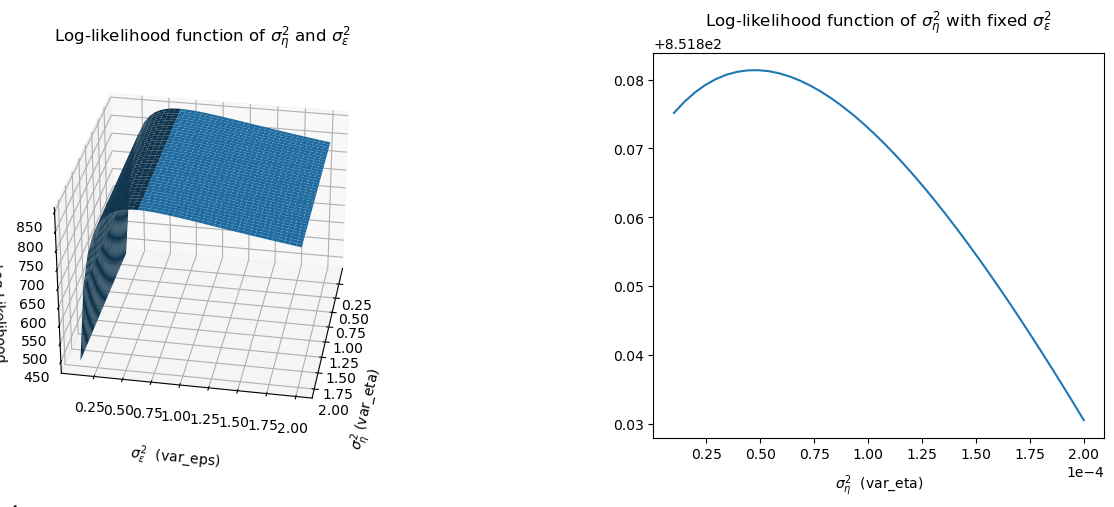

In [28]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2])
ax = fig.add_subplot(gs[0], projection="3d")
ax2 = fig.add_subplot(gs[1])
ax.plot_surface(Y_grid, X_grid, V_grid)  # , cmap=cm.ocean
ax.set_title("Log-likelihood function of $\sigma_{\eta}^2$ and $\sigma_{\epsilon}^2$")
ax.set_xlabel("$\sigma_{\eta}^2$ (var_eta)                    ", labelpad=9)
ax.set_ylabel("$\sigma_{\epsilon}^2$  (var_eps)", labelpad=13)
ax.set_zlabel("Log-Likelihood", labelpad=7)
ax.view_init(30, 10)  # this function rotates the 3d plot
ax.ticklabel_format(axis="x", style="sci", scilimits=(-4, 2))
ax.ticklabel_format(axis="y", style="sci", scilimits=(-4, 2))
ax2.plot(var_eta_y, V)
ax2.set_title("Log-likelihood function of $\sigma_{\eta}^2$ with fixed $\sigma_{\epsilon}^2$")
ax2.set_xlabel("$\sigma_{\eta}^2$  (var_eta)", labelpad=8)
ax2.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.show()

##### Comments:
- The log-likelihood is a concave function of $\sigma_{\eta}^2$. Therefore there is a global maximum.    

- Sometimes, it happens that the log-likelihood is a decreasing function of $\sigma_{\eta}^2$. Therefore the maximum is at $\sigma_{\eta}^2 = 0$. In this case the value doesn't make sense. 
If we use $\sigma_{\eta}=0$, it means that we are considering the process model as a perfect model (with no error). 
The consequence is that the filter will hardly be affected by new measurements. 

- The log-likelihood is concave with respect to $\sigma_{\epsilon}^2$ and has a maximum point (for each fixed $\sigma_{\eta}^2$). This is very good!      
We can see that the MLE estimator is very close to the OLS estimator!!

In [29]:
KR.calibrate_MLE()

print("beta_last = ", KR.betas[-1], "P_last = ", KR.Ps[-1])
print("var_eta_MLE = ", KR.var_eta, "var_eps_MLE = ", KR.var_eps, "var_eps_OLS = ", var_eps_ols)

KR.run(ret_test[X], ret_test[Y])

print("The post-fit R squared is: ", KR.R2_post_fit)

Optimization converged successfully
var_eps = 6.250650685447434e-05, var_eta = 6.250079206505446e-05
beta_last =  1.0132897275906843 P_last =  0.012048131591893373
var_eta_MLE =  6.250079206505446e-05 var_eps_MLE =  6.250650685447434e-05 var_eps_OLS =  6.286775484858256e-05
The post-fit R squared is:  0.4532263803195352


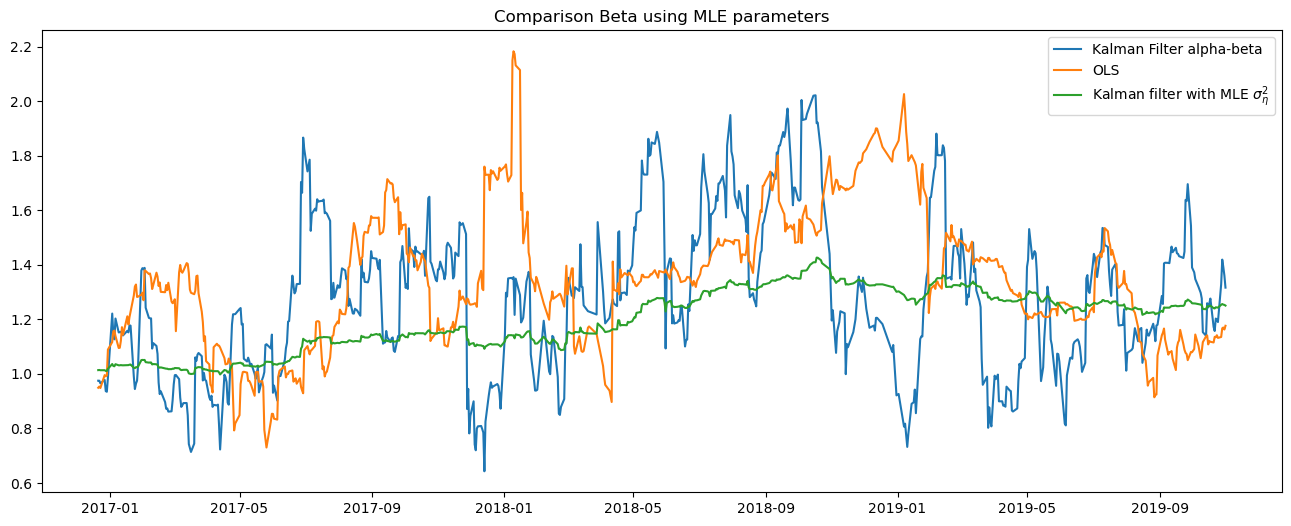

In [30]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test.index, betas, label="Kalman Filter alpha-beta")
plt.plot(ret_test["ols_beta"], label="OLS")
plt.plot(ret_test.index, KR.betas, label="Kalman filter with MLE $\sigma_{\eta}^2$")
plt.legend()
plt.title("Comparison Beta using MLE parameters")
plt.show()

In [31]:
ret_test = ret_test.assign(Kalman_beta=KR.betas)
ret_test = ret_test.assign(Kalman_err=np.sqrt(KR.Ps))
ret_test.head()

,GOOGL,^GSPC,ols_beta,ols_std_err,ols_alpha,Kalman_beta,Kalman_err
Date,,,,,,,
2016-12-21,-0.003687,-0.002460,0.949317,0.154658,-0.000213,1.013967,0.109984
2016-12-22,-0.003108,-0.001865,0.953851,0.156574,-0.000446,1.014490,0.110230
2016-12-23,-0.002325,0.001251,0.948372,0.169485,-0.000989,1.013556,0.110497
2016-12-27,0.002633,0.002246,0.995708,0.175753,-0.000775,1.013613,0.110724
2016-12-28,-0.006640,-0.008392,0.991182,0.177171,-0.000622,1.010940,0.110244


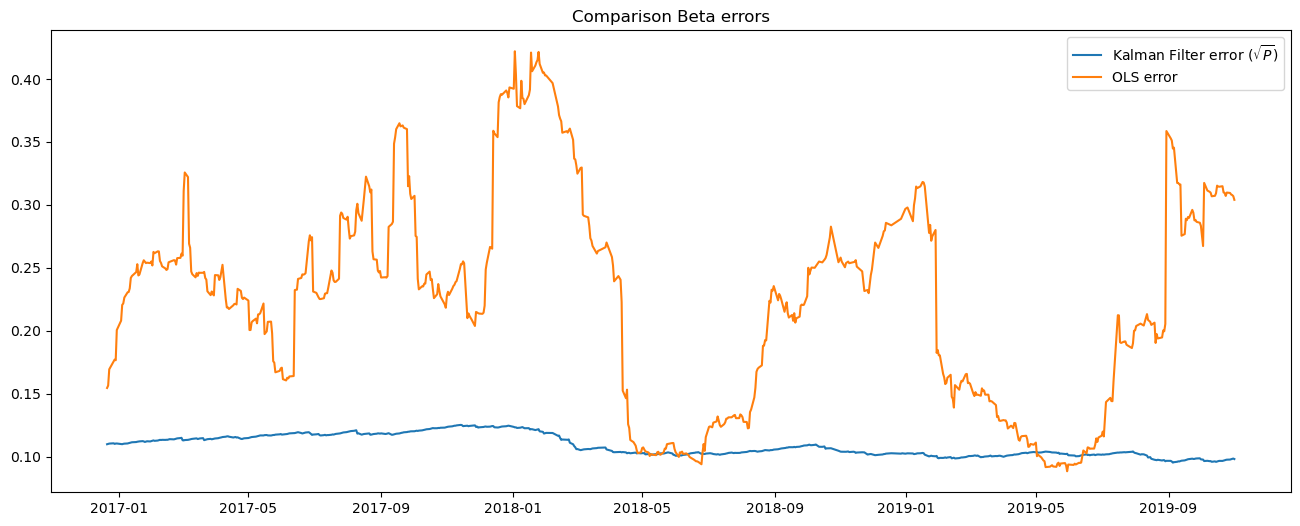

In [32]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test["Kalman_err"], label="Kalman Filter error ($\sqrt{P}$)")
plt.plot(ret_test["ols_std_err"], label="OLS error")
plt.legend()
plt.title("Comparison Beta errors")
plt.show()

The error comparison above is only indicative. Since the OLS error $\sqrt{ \frac{\sigma^2}{S_{xx}} }$ can be set arbitrarily small by simply choosing a bigger time window (the more data we have, the higher $S_{xx}$ will be).

### Quite good!
Using the Kalman filter we obtain very smooth values of beta. The estimation error is smaller and smoother as well. 

## What about the $R^2$ ? 

A possible alternative to the MLE, could be to maximize the $R^2$.     
Let us see if it works.

The following function considers a fixed $\sigma_{\epsilon}$ and searches for the optimal value of $\sigma_{\eta}$ in the range `bounds=[[1e-15,1]]`.

There are two reasons to calibrate only one parameter. 
- The first reason is that we have already seen that $\sigma_{\epsilon}$ obtained with OLS is a good value. It is very close to the MLE estimate.
- The second reason is that the $R^2$ is maximized at $\sigma_{\epsilon} = 0$ and for a high value of $\sigma_{\eta}$. When the measurement error is zero, it means that the measurements are perfect and the Kalman filter simply selects the values of beta that solve the linear equation $y_k = \alpha + \beta_k x_k$. Of course $\sigma_{\eta}$ should be big enough to allow fast changes of beta. In this case we have an **overfitting** problem. Using a high $\sigma_{\eta}$ also means that our process model has a very low predictive power.

Let us see what happens when calibrating only $\sigma_{\eta}$.

In [33]:
KR.calibrate_R2(mode="pre-fit")

Optimization converged successfully
var_eta = 1e-15


In [34]:
KR.calibrate_R2(mode="post-fit")

Optimization converged successfully
var_eta = 1.0


- Considering the *pre-fit* residuals, the optimizer returns the output $\sigma_{\eta}^2 = 10^{-15}$, which is the lowerbound imposed by myself. This is not an acceptable value.

- Considering the *post-fit* residuals, the output is the upper bound in the parameter range `bounds=[[1e-15,1]]`. **Overfitting**   

By looking at the picture below, we see that the $R^2$ is an increasing function of $\sigma_{\eta}$, i.e. there is no optimal $\sigma_{\eta}$.

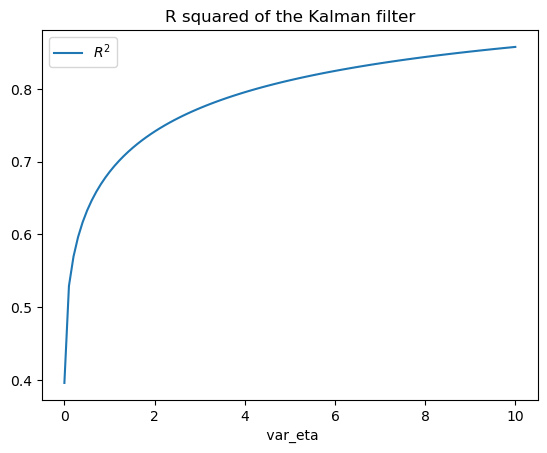

In [35]:
xx = np.linspace(0.000001, 10, 100)
RR2 = []
for i in xx:
    KR.run(var_eta=i, var_eps=var_eps_ols)
    RR2.append(KR.R2_post_fit)
plt.plot(xx, RR2, label="$R^2$")
plt.title("R squared of the Kalman filter")
plt.xlabel(" var_eta")
plt.legend()
plt.show()

##### Well... The $R^2$ maximization is not a good idea! It doesn't work.

Let us see what happens if we run the Kalman filter in the test set using a big value of $\sigma_{\eta}$ and a small value of $\sigma_{\epsilon}$ (here I set $\sigma_{\epsilon}^2$ to var_eps_ols).   

In [36]:
var_eta_R2 = 200
KR.run(ret_test[X], ret_test[Y], var_eta=var_eta_R2, var_eps=var_eps_ols)

print("The post-fit R squared is: ", KR.R2_post_fit)

The post-fit R squared is:  0.9572452482415568


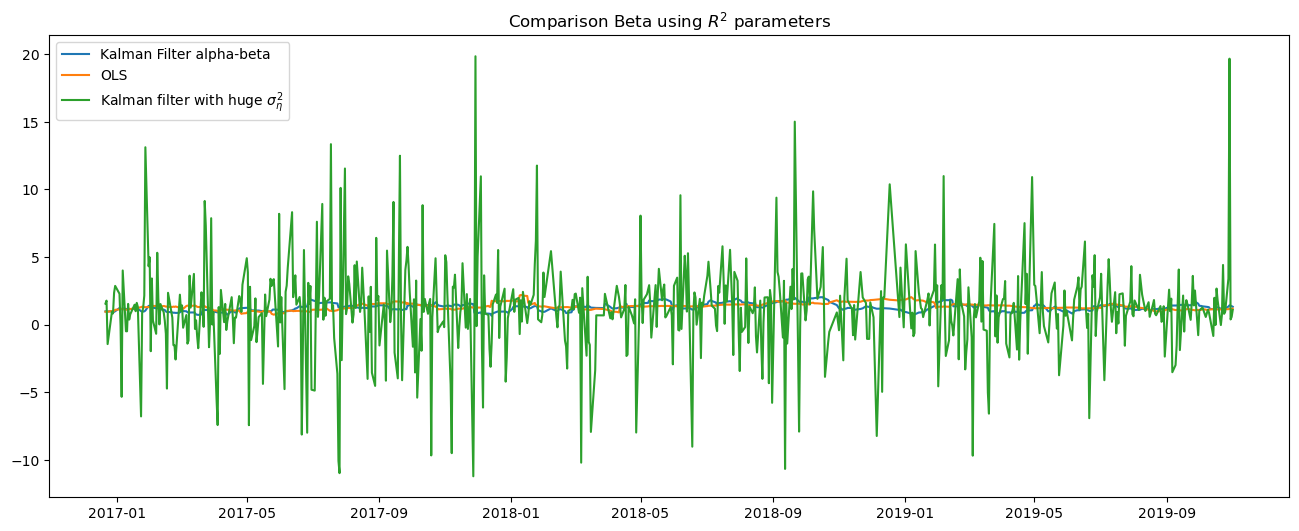

In [37]:
plt.figure(figsize=(16, 6))
plt.plot(ret_test.index, betas, label="Kalman Filter alpha-beta")
plt.plot(ret_test["ols_beta"], label="OLS")
plt.plot(ret_test.index, KR.betas, label="Kalman filter with huge $\sigma_{\eta}^2$")
plt.legend()
plt.title("Comparison Beta using $R^2$ parameters")
plt.show()

The $R^2$ is very close to 1, which means almost a perfect fit. However the obtained values of $\beta$ are unreasonable. 

#### Conclusions

- We have seen that using the $R^2$ for the calibration is not a good idea because it produces **overfitting**.

- The MLE sometimes works, sometimes not. Most of the time, the problematic parameter to estimate is $\sigma_{\eta}$.

- The OLS estimator for $\sigma_{\epsilon}$ is very close to the MLE for $\sigma_{\epsilon}$.

- The parameter $\sigma_{\eta}$ must be chosen by the filter designer, using reasonable assumptions. 

## References

[1] Casella, George and Berger, Roger. (2001) "Statistical inference" Duxbury Advanced Series 